In [1]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)

from utility.utils import generate_t, a_order_power_mean, transaction_cost_L

In [2]:
t, s_t = generate_brownian_path(
    n_steps=250, T=1, H=0.8, mu=0.15, sigma=0.2, s0=100, brownian_type="fractional"
)

Computing fBm increments...:   0%|          | 0/250 [00:00<?, ?it/s]

Price process : $$s^i_t=s^i_0\times e^{\mu^it+\sigma^iB_t^{H^i}}$$


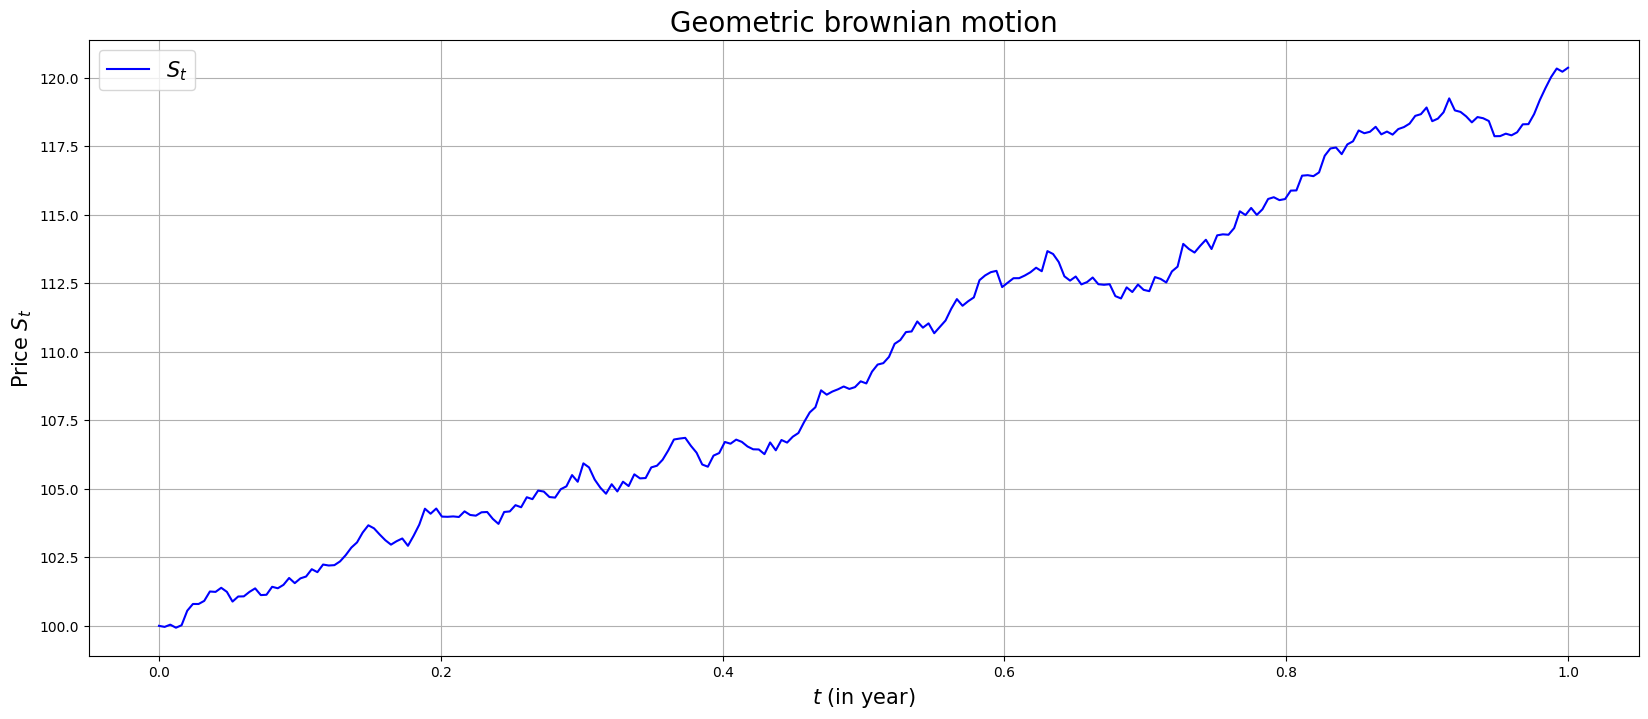

In [3]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(
    t,
    s_t,
    color="blue",
    label="$S_t$",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel("Price $S_t$", fontsize=15)
ax.set_title(f"Geometric brownian motion", fontsize=20)
ax.grid()
ax.legend(fontsize=15)

- Portfolio value at time $t$ : $$V^\Psi_t=\sum^d_{i=0}\Psi_t^iS_t^i$$
- Gain process at time $t$ : $$G^\Psi_t=\sum^d_{i=0}\int_0^t\Psi_t^idS_t^i$$
- Portfolio value at time $t$ : $$V^\Psi_t=\nu+G^\Psi_t$$


# Salopek strategy

Another arbitrage strategy, dating back to Harrison et al. (1984) and applied in a fractional Black-Scholes market by Salopek (1998), trades $d \geq 2$ risky assets and ignores the risk-free asset. It is defined for two real-valued constants $\alpha<\beta$ and can be summarized as $\Psi=(0, \Psi(\alpha, \beta))$ or, with some abuse of notation, $\Psi=\Psi(\alpha, \beta)$. The entries of $\Psi(\alpha, \beta)=\left(\Psi_{t}^{1}(\alpha, \beta), \ldots, \Psi_{t}^{d}(\alpha, \beta)\right)$ are the risky asset shares at time $t \in[0, T]$. Specifically, for $i=1, \ldots, d$, we have

$$
\begin{equation*}
\Psi_{t}^{i}(\alpha, \beta)=\widehat{\Psi}_{t}^{i}(\beta)-\widehat{\Psi}_{t}^{i}(\alpha), \quad \text { where } \quad \widehat{\Psi}_{t}^{i}(a)=\frac{1}{d}\left(\frac{S_{t}^{i}}{M_{a}\left(S_{t}\right)}\right)^{a-1} \tag{2.10}
\end{equation*}
$$

$M_{a}(x)$ denotes the $a$-order power mean of $x=\left(x^{1}, \ldots, x^{d}\right) \in \mathbb{R}_{+}^{d}$. It is given by

$$
\begin{array}{ll}
M_{a}(x)=\left(\frac{1}{d} \sum_{i=1}^{d}\left(x^{i}\right)^{a}\right)^{1 / a} \quad \text { for } \quad a \neq 0  \tag{2.11}\\
M_{0}(x)=\sqrt[d]{x^{1} \cdot \ldots \cdot x^{d}} \quad \text { for } \quad a=0
\end{array}
$$

Remark 2.2 With respect to the properties of the a-order power mean, we can list the following important special cases:

$$
\begin{aligned}
& M_{1}(x)=\left(x^{1}+\ldots+x^{d}\right) / d \quad \text { (arithmetic mean) } \\
& M_{2}(x)=\sqrt{\left(\left(x^{1}\right)^{2}+\ldots+\left(x^{d}\right)^{2}\right) / d} \quad \text { (quadratic mean) } \\
& M_{-1}(x)=\left(\left(1 / x^{1}+\ldots+1 / x^{d}\right) / d\right)^{-1} \quad \text { (harmonic mean) } \\
& M_{0}(x)=\sqrt[d]{x^{1} \cdot \ldots \cdot x^{d}}=\lim _{a \rightarrow 0} M_{a}(x) \quad \text { (geometric mean) } \\
& M_{\infty}(x):=\lim _{a \rightarrow+\infty} M_{a}(x)=x_{\max }=\max \left\{x^{1}, \ldots, x^{d}\right\} \quad(\text { maximum of } x) \\
& M_{-\infty}(x):=\lim _{a \rightarrow-\infty} M_{a}(x)=x_{\min }=\min \left\{x^{1}, \ldots, x^{d}\right\} \quad(\text { minimum of } x)
\end{aligned}
$$

The strategy $\Psi(\alpha, \beta)$ in (2.10) is expressed as the difference between $\widehat{\Psi}(\beta)$ and $\widehat{\Psi}(\alpha)$. Because these two components can be considered as strategies themselves, we call $\widehat{\Psi}(a)$ an a-strategy or a-portfolio. Consequently, an investor can implement $\Psi(\alpha, \beta)$ by purchasing a $\beta$-portfolio and short-selling an $\alpha$-portfolio.

Substituting the $\widehat{\Psi}(a)$ specified by (2.10) into (2.5) provides the portfolio value of an $a$-strategy, i.e., we obtain

$$
\begin{equation*}
V_{t}^{\widehat{\Psi}(a)}=M_{a}\left(S_{t}\right) . \tag{2.13}
\end{equation*}
$$


In [4]:
df_ptf = generate_n_assets_portfolio(
    2,
    n_steps=250,
    T=1,
    H=0.7,
    mu=0.05,
    sigma=0.1,
    s0=100,
    add_risk_free_asset=False,
    as_dataframe=True,
    brownian_type="fractional",
)
df_ptf

,S_1_t,S_2_t
0.000000,100.000000,100.000000
0.004016,100.262153,100.023867
0.008032,100.238317,99.827889
0.012048,100.413774,100.079854
0.016064,100.439108,100.279006
...,...,...
0.983936,107.232191,104.165385
0.987952,106.820264,104.182685
0.991968,106.941387,103.991055
0.995984,107.335909,104.323610


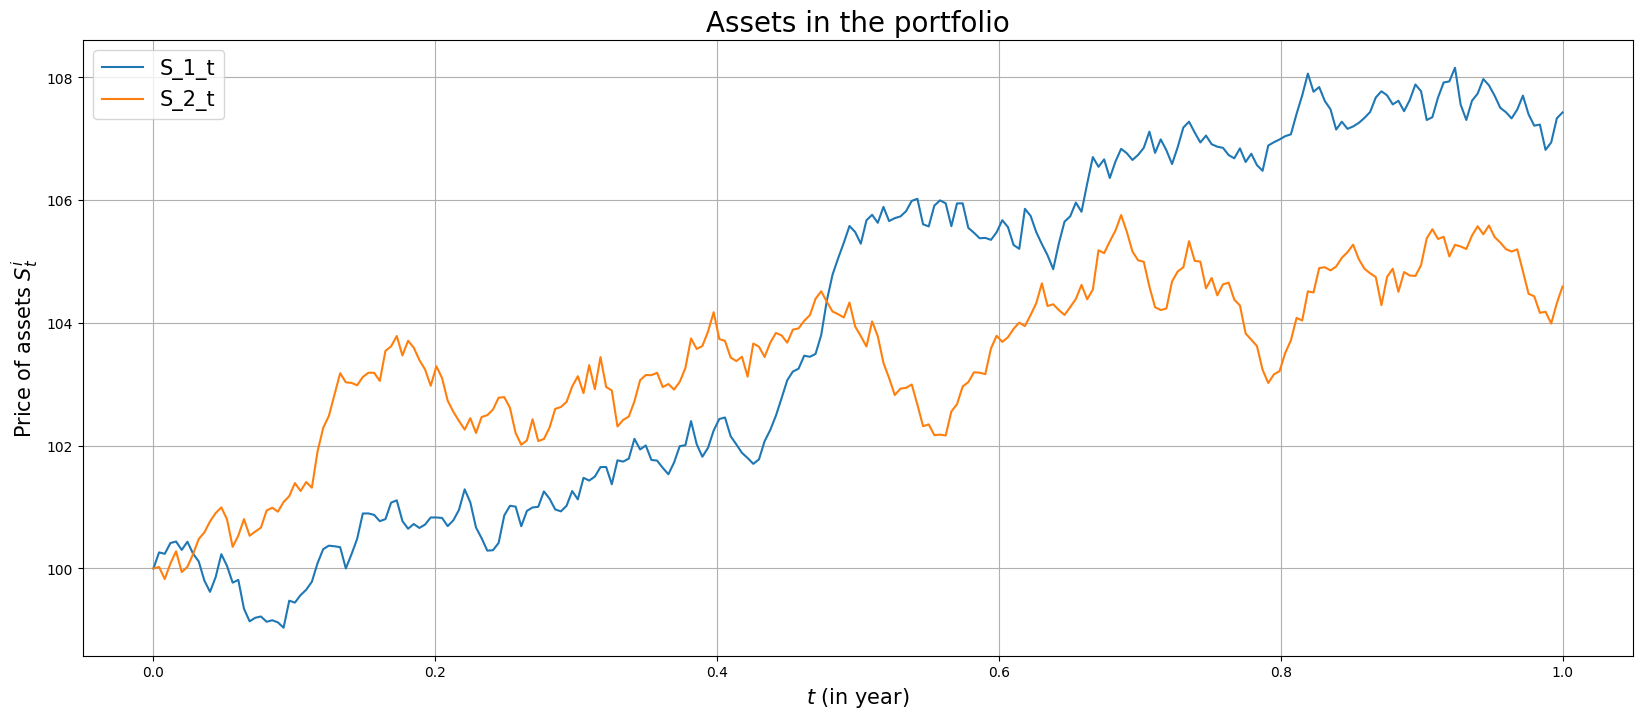

In [5]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
for col in df_ptf.columns:
    ax.plot(
        df_ptf[col],
        label=f"{col}",
    )

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax.set_title(f"Assets in the portfolio", fontsize=20)
ax.grid()
ax.legend(fontsize=15)

$$\Psi_t^i(a)=\frac{1}{d}\times(\frac{S_t^i}{M_a(S_t)})^{a-1}$$
and $$\Phi_n^i=\Psi_{t-1}^i \quad i=1,...,d$$


In [6]:
def phi_i(a: int, s_i_t: float, s_t: npt.NDArray[np.float64]) -> np.float64:
    """Equation 2.10

    Args:
    ----
        a (int): a-order power of the mean
        s_i_t (float): The price of asset i at time t
        s_t (npt.NDArray[np.float64]): The array of all assets at time t

    Returns:
    ----
        np.float64: Salopek strategy quantity allocation at time t for asset i.
    """
    d = int(s_t.shape[0])
    return (1 / d) * (((s_i_t / a_order_power_mean(x=s_t, a=a))) ** (a - 1))

Transaction cost : $$L_t^\Phi=l(\Gamma_t^\Phi,p) \quad \text { with } \quad l(y,p)=max(p_1y,p_2)\mathbb{1}_{\{y>0\}}$$
And $p=(p_1,p_2)$


# Running the strategy


In [64]:



ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


# quantities = [[0.0 for _ in range(df_ptf.shape[-1])]]  # Phi_i_t
quantities = []  # Phi_i_t
volumes = []  # \Gamma_t

transaction_costs = []  # L_t
transaction_account = []  # D_t
transaction_account_qty = []  # \Phi_{t}^{d+1}

V_t_psi = []  # Using equation 2.14/2.22
V_t_phi = []  # Using equation 2.21

for index, row in tqdm(
    df_ptf.iterrows(),
    desc="Running the strategy...",
    leave=False,
):  ###################### Compute the new quantity (Equation 2.10) ###############################
    new_quantity = [
        SCALING_FACTOR
        * float(
            phi_i(a=BETA, s_i_t=asset_i, s_t=row.to_numpy())
            - phi_i(a=ALPHA, s_i_t=asset_i, s_t=row.to_numpy())
        )
        for asset_i in row
    ]
    quantities.append(new_quantity)
    ###################### Volume section (Equation 2.26) ###############################
    if index == df_ptf.index[0] or index == df_ptf.index[-1]: # Repurchasing or liquidating 
        volumes.append(np.array(tuple(map(abs, quantities[-1]))) @ row.to_numpy())
    else:
        volumes.append(
            np.array(
                tuple(map(abs, np.array(quantities[-1]) - np.array(quantities[-2])))
            )
            @ row.to_numpy()
        )
        
    ###################### Transaction cost section ###############################
    # Equation 2.17 : L_t^\Phi
    transaction_costs.append(transaction_cost_L(volumes[-1], p_1=P1, p_2=P2))
    
    
    
    ###################### Transaction account section ###############################
    # Equation 2.19 : D_t^\Phi
    if index != df_ptf.index[0]  or index != df_ptf.index[-1]: # Because 1.19 n between 1 and N-1
        try:
            transaction_account.append(
                (np.array(quantities[-1]) - np.array(quantities[-2])) @ row.to_numpy()
            )
        except:
            transaction_account.append(
                (np.array(quantities[-1]) - 0) @ row.to_numpy()
            )

    else:
        transaction_account.append(0)
        
    ###################### Transaction account quantity section (Equation 2.20) ###############################
    # Equation 2.20 : \Phi_t^{d+1}
    if index == df_ptf.index[0]:
        transaction_account_qty.append(-transaction_costs[-1])
        
    elif index == df_ptf.index[-1]:
        net_revenue = (np.array(quantities[-1]) @ row.to_numpy()) - transaction_costs[
            -1
        ]  # Equation 2.18 : R^\Gamma
        transaction_account_qty.append(transaction_account_qty[-1] + net_revenue)
        
    else:
        transaction_account_qty.append(
            transaction_account_qty[-1]
            - transaction_account[-1]
            - transaction_costs[-1]
        )
    ###################### Portfolio value ###############################
    # Using equation 2.14
    # V_t_psi.append(
    #     SCALING_FACTOR*(a_order_power_mean(x=row.to_numpy(), a=BETA)
    #     - a_order_power_mean(x=row.to_numpy(), a=ALPHA))
    # )
    # Using equation 2.21
    V_t_phi.append(np.array(quantities[-1]) @ row.to_numpy())  # Discrete # +1*transaction_account_qty[-1]
    # Using equation 2.22
    V_t_psi.append(V_t_phi[-1] - transaction_account[-1])  # Continuous
    
   


weights_df = pd.DataFrame(
    quantities,
    index=df_ptf.index,
    columns=[f"phi_{i}" for i in range(1, len(quantities[0]) + 1)],
)

Liquidation :

$$R^\Phi=\sum_{i=0}^d\Phi_N^iS_T^i-L^\Phi_T$$



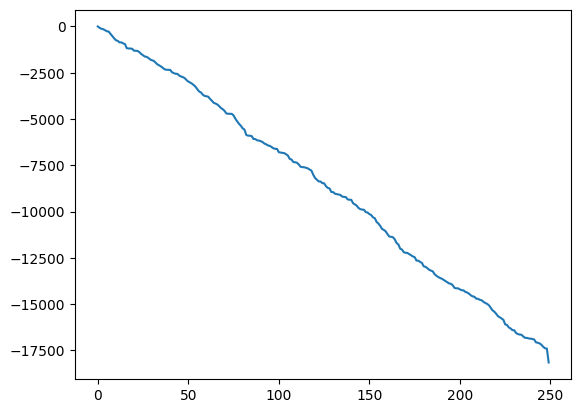

In [68]:
plt.plot(transaction_account_qty) #\Phi_t^{d+1}

In [66]:
# Net revenue
net_revenue = (
    np.array(quantities[-1]) @ df_ptf.iloc[-1].to_numpy()
) - transaction_costs[-1]
net_revenue

-752.5347199258396

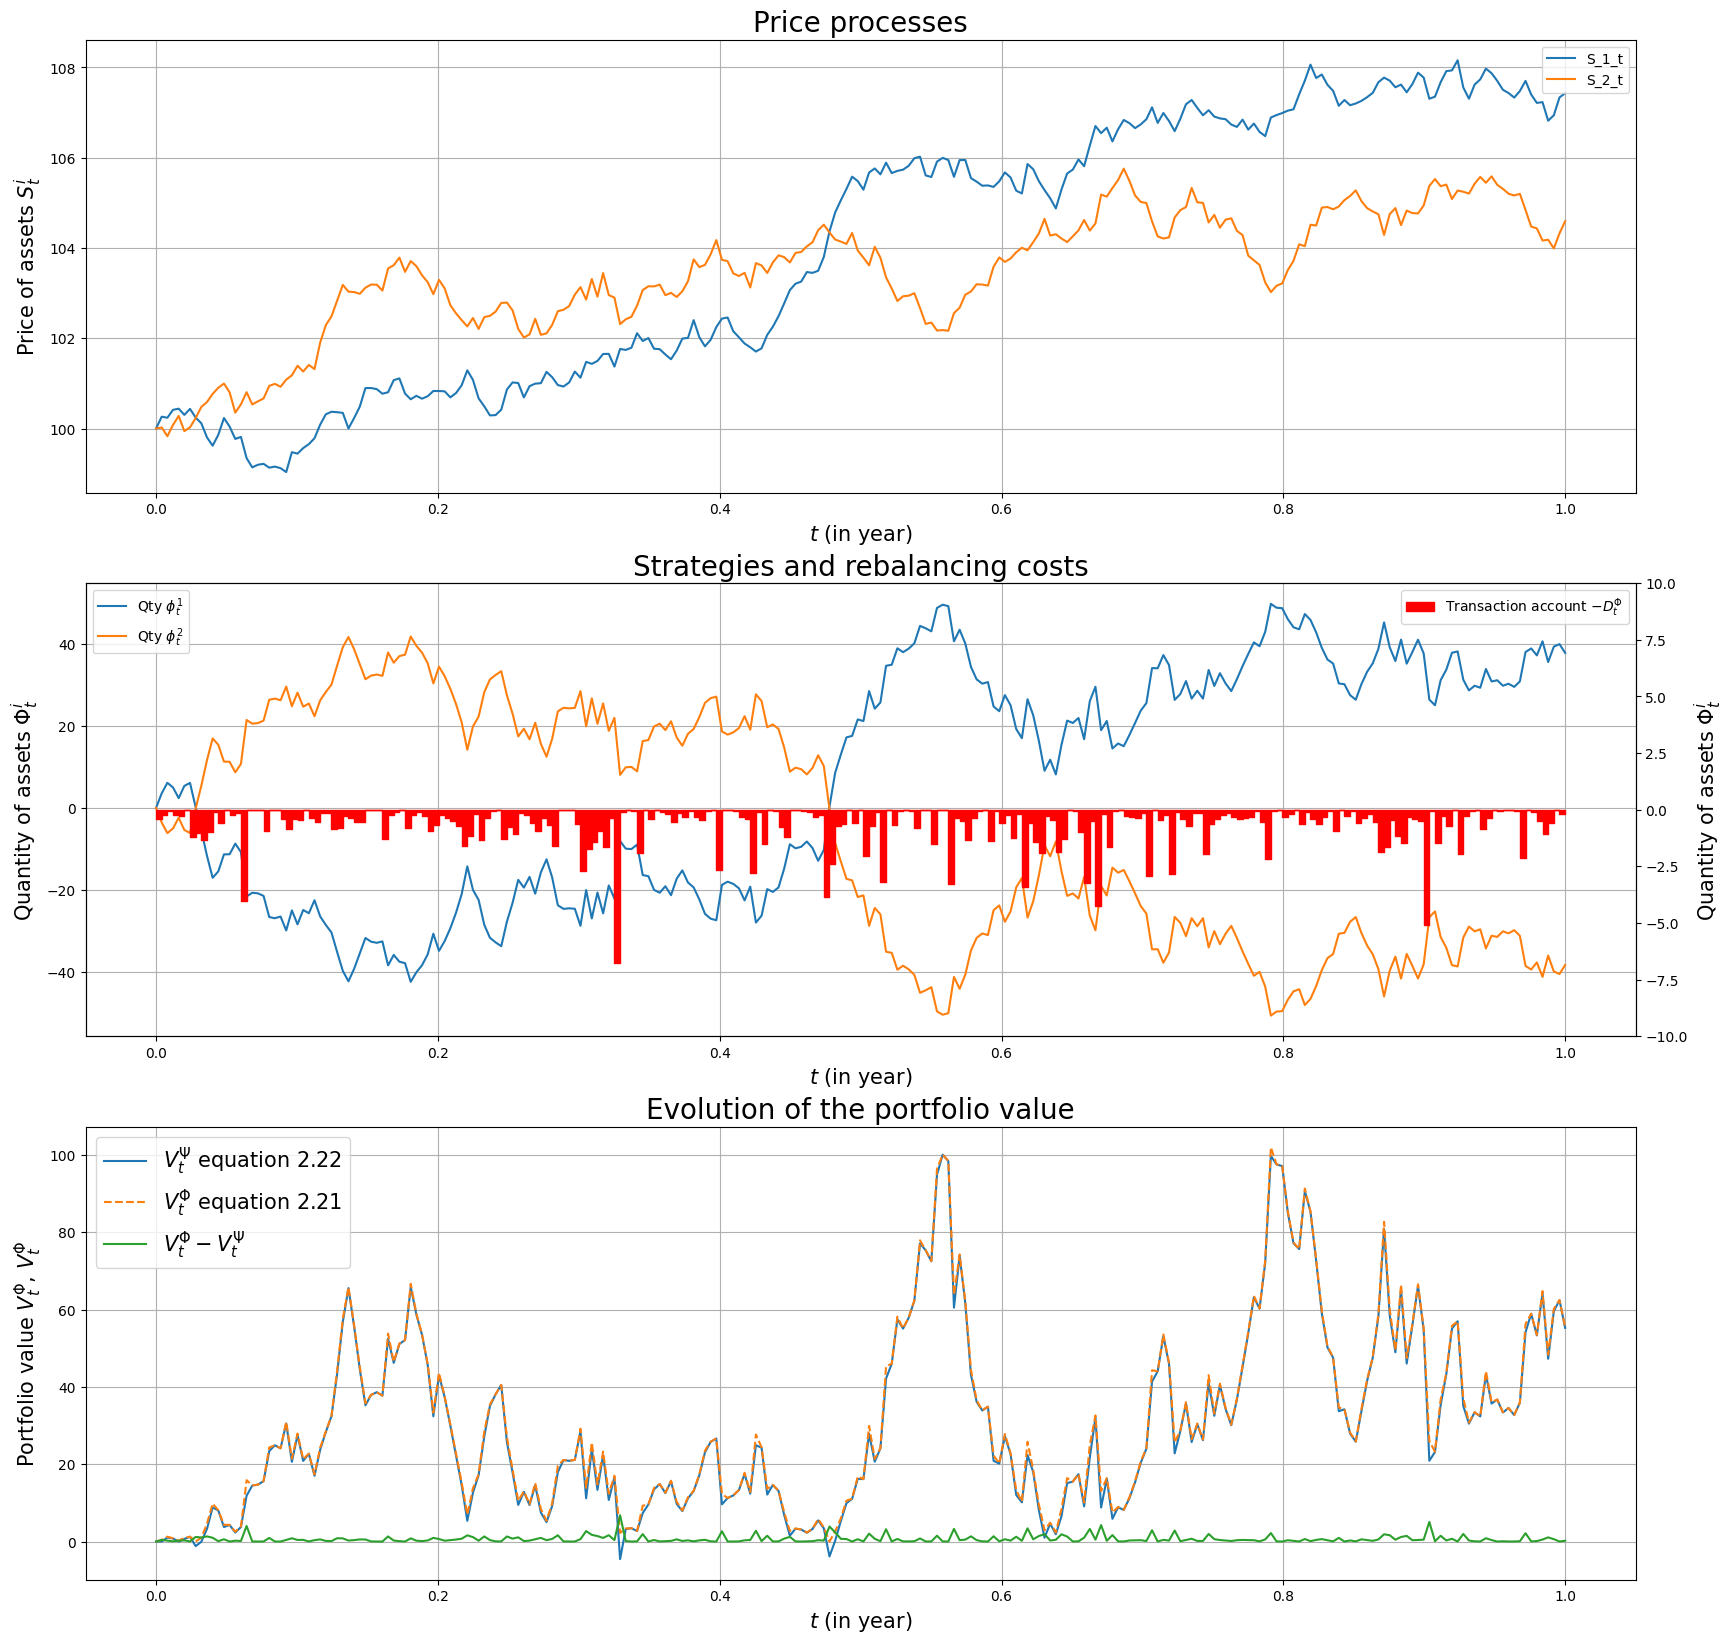

In [67]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_ptf.columns:
    ax[0].plot(
        df_ptf[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_ptf.index,
    -np.array(transaction_account),
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylim([-10,10])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
ax[2].plot(
    df_ptf.index,
    V_t_psi,
    label=r"$V_t^\Psi$ equation 2.22",
)
ax[2].plot(
    df_ptf.index,
    V_t_phi,
    linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
)
ax[2].plot(
    df_ptf.index,
    np.array(V_t_phi) - np.array(V_t_psi),
    label=r"$V_t^\Phi-V_t^\Psi$",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
ax[2].legend(fontsize=15)

# Idées

- Vol sto
- Données réelles avec exposant de Hurst cross section
- Prouver arbitrage pourquoi H>0.5 fonctionne et pas H=0.5 (dominance sto ?)
-
